## Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import distance_matrix
from adjustText import adjust_text
from matplotlib.patches import Polygon

## Datos

In [3]:
# Ruta al archivo
file_path = "../data/Towns_HB_2024-08-14.xlsx"

# Leer todas las hojas como un diccionario {nombre_hoja: DataFrame}
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Filtrar solo las hojas que tienen datos (al menos una fila no vacía)
non_empty_sheets = {name: df for name, df in all_sheets.items() if not df.dropna(how='all').empty}

# Mostrar nombres de hojas con datos
print(f"Hojas con datos: {list(non_empty_sheets.keys())}")

Hojas con datos: ['Towns', 'Triple Alliance towns', 'Tenochtitlan', 'Zempoala', '79 Destinations', 'Tecpilpan']


In [4]:
df_towns = non_empty_sheets["Towns"]
df_triple_alliance = non_empty_sheets["Triple Alliance towns"]
df_tenochtitlan = non_empty_sheets["Tenochtitlan"]
df_zempoala = non_empty_sheets["Zempoala"]
df_79 = non_empty_sheets["79 Destinations"]
df_tecpilpan = non_empty_sheets["Tecpilpan"]

### Definir coordenadas y pueblos

In [5]:
coords = df_towns[["Longitude", "Latitude"]].values
names = df_towns["Toponym"].values

### Muestra de cuatro datos

In [6]:
# Indices you want (zero-based)
indices = [68, 70, 71]

# Get names by index
selected_names = names[indices]
selected_coords = coords[indices]
print(selected_names)

['Mizquiyahualan' 'Tezcatepec' 'Chilcuauhtlan']


In [8]:
# Extract longitude and latitude
longitudes = selected_coords[:, 0]
latitudes = selected_coords[:, 1]

# Identify points
idx_mizqui = np.where(selected_names == 'Mizquiyahualan')[0][0]
idx_chilcua = np.where(selected_names == 'Chilcuauhtlan')[0][0]
idx_tezca = np.where(selected_names == 'Tezcatepec')[0][0]

mizqui = selected_coords[idx_mizqui]
chilcua = selected_coords[idx_chilcua]
tezca = selected_coords[idx_tezca]

# Compute Euclidean distance (in degrees)
radius = np.linalg.norm(mizqui - chilcua)
radius2 = np.linalg.norm(tezca - chilcua)

In [9]:
# === Define triangle points ===

# Get index of each point in selected_names
idx_mizqui = np.where(selected_names == 'Mizquiyahualan')[0][0]
idx_tezca = np.where(selected_names == 'Tezcatepec')[0][0]
# idx_tezonte = np.where(selected_names == 'Tezontepec 2 (de Aldama); Teçuntepeque')[0][0]
idx_chilcua = np.where(selected_names == 'Chilcuauhtlan')[0][0]

# === Triangle 1 ===
triangle1_coords = np.array([
    selected_coords[idx_mizqui],      # index 0: j
    selected_coords[idx_tezca],       # index 1: k
    selected_coords[idx_chilcua]      # index 2: i
])
triangle1_roles = [('j', 'Mizquiyahualan'), ('k', 'Tezcatepec'), ('i', 'Chilcuauhtlan')]

# === Triangle 2 ===
triangle2_coords = np.array([
    selected_coords[idx_tezca],       # index 0: j
    selected_coords[idx_mizqui],      # index 1: k
    selected_coords[idx_chilcua]      # index 2: i
])
triangle2_roles = [('j', 'Tezcatepec'), ('k', 'Mizquiyahualan'), ('i', 'Chilcuauhtlan')]



In [10]:
from matplotlib.patches import Circle

def plot_triangle_with_labels(
    ax,
    triangle_coords,
    triangle_roles,
    title,
    mizqui,
    chilcua,
    radius,
    ij_edge,
    node_label_offsets,
    edge_label_offsets
):
    """
    Plot a triangle with labeled segments and point labels.
    - The (p_i, p_j) edge is colored red (specified by ij_edge).
    - Other edges are blue.
    - Custom label offsets are supported for both nodes and edges.

    Parameters:
        ax: Matplotlib axis
        triangle_coords (3x2 array): Triangle vertex coordinates
        triangle_roles (list of tuples): [('i', 'NameA'), ('j', 'NameB'), ('k', 'NameC')]
        title (str): Title of subplot
        mizqui, chilcua: Centers for dashed circles
        radius (float): Radius of dashed circles
        ij_edge (tuple): Indices (e.g., (0, 2)) specifying the red edge
        node_label_offsets (dict): Offsets for nodes, e.g., {'i': (10, 10), 'j': (-10, 5)}
        edge_label_offsets (dict): Offsets for edges, e.g., {('i','j'): (10,10)}
    """

    # Draw triangle edges
    for i in range(3):
        a = triangle_coords[i]
        b = triangle_coords[(i + 1) % 3]

        role_a, _ = triangle_roles[i]
        role_b, _ = triangle_roles[(i + 1) % 3]
        current_edge = {i, (i + 1) % 3}
        current_roles = tuple(sorted([role_a, role_b]))

        # Color: red if designated (p_i, p_j), otherwise blue
        if current_edge == set(ij_edge):
            edge_color = 'red'
        else:
            edge_color = 'blue'

        # Draw edge
        ax.plot([a[0], b[0]], [a[1], b[1]], color=edge_color, linewidth=2)

        # Edge label at midpoint
        mid_x = (a[0] + b[0]) / 2
        mid_y = (a[1] + b[1]) / 2
        offset = edge_label_offsets.get(current_roles, (0, 0))
        ax.annotate(
            rf"$d(p_{{{role_a}}},\ p_{{{role_b}}})$",
            xy=(mid_x, mid_y),
            xytext=offset,
            textcoords='offset points',
            fontsize=10,
            color=edge_color,
            ha='center'
        )

    # Draw nodes
    ax.scatter(triangle_coords[:, 0], triangle_coords[:, 1], color='blue', s=100, edgecolors='black')

    # Node labels
    for (x, y), (role, name) in zip(triangle_coords, triangle_roles):
        offset = node_label_offsets.get(role, (0, 0))
        label = rf"$p_{{{role}}}$ ({name})"
        ax.annotate(
            label,
            xy=(x, y),
            xytext=offset,
            textcoords='offset points',
            fontsize=9,
            ha='center',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', lw=0.5)
        )

    # Circles
    circle1 = Circle(mizqui, radius=radius, edgecolor='red', facecolor='none', linestyle='--', linewidth=2, alpha=0.7)
    circle2 = Circle(chilcua, radius=radius, edgecolor='green', facecolor='none', linestyle='--', linewidth=2, alpha=0.7)
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal')
    ax.grid(True)


In [11]:
node_label_offsets1 = {
    'i': (-30, 10),
    'j': (60, 0),
    'k': (-40, -20)
}

edge_label_offsets1 = {
    ('i', 'j'): (25, 12),
    ('i', 'k'): (-30, -20),
    ('j', 'k'): (-25, -10)
}

node_label_offsets2 = {
    'i': (-30, 10),
    'j': (-40, -20),
    'k': (60, 0)
}

edge_label_offsets2 = {
    ('i', 'j'): (-30, -20),
    ('i', 'k'): (25, 12),
    ('j', 'k'): (-25, -10)
}

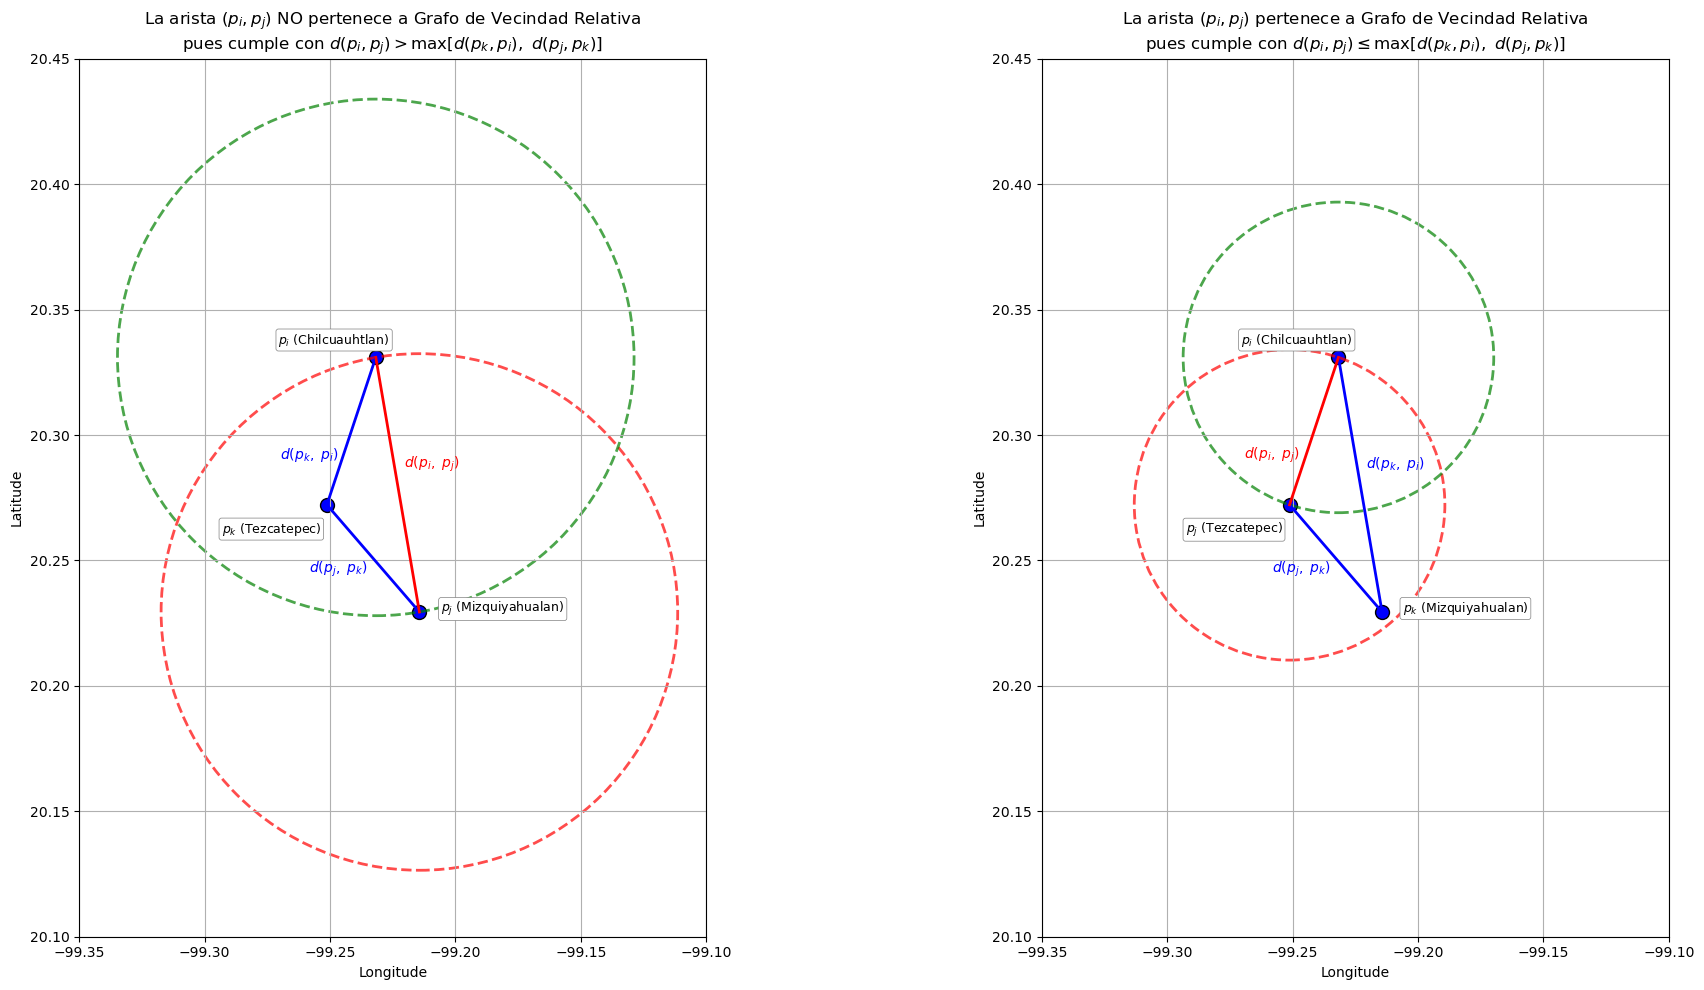

In [15]:
import matplotlib.pyplot as plt

# Crear los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Primer gráfico — d(p_i, p_j) es entre Mizquiyahualan y Chilcuauhtlan
plot_triangle_with_labels(
    ax1,
    triangle_coords=triangle1_coords,
    triangle_roles=triangle1_roles,
    title="La arista $(p_i, p_j)$ NO pertenece a Grafo de Vecindad Relativa\npues cumple con $d(p_i, p_j) > \\max[d(p_k, p_i),\ d(p_j, p_k)]$",
    mizqui=mizqui,
    chilcua=chilcua,
    radius=radius,
    ij_edge=(0, 2),
    node_label_offsets=node_label_offsets1,
    edge_label_offsets=edge_label_offsets1
)

# Segundo gráfico — d(p_i, p_j) es entre Chilcuauhtlan y Tezcatepec
plot_triangle_with_labels(
    ax2,
    triangle_coords=triangle2_coords,
    triangle_roles=triangle2_roles,
    title="La arista $(p_i, p_j)$ pertenece a Grafo de Vecindad Relativa\npues cumple con $d(p_i, p_j) \\leq \\max[d(p_k, p_i),\ d(p_j, p_k)]$",
    mizqui=tezca,
    chilcua=chilcua,
    radius=radius2,
    ij_edge=(0, 2),
    node_label_offsets=node_label_offsets2,
    edge_label_offsets=edge_label_offsets2
)



xlim = (-99.35, -99.10)
ylim = (20.10, 20.45)

# Apply to both axes
for ax in (ax1, ax2):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


plt.tight_layout()
plt.show()


## Algoritmo

### Calculo de la matriz de distancias

(i)    Calcular la distancia entre todos los pares de puntos $d(p_i,P_j)$, con $i, j = 1, 2, ..., n$; y $i>j$

In [ ]:
def euclidean_distance_matrix_symmetric(coords):
    """
    Computes a symmetric Euclidean distance matrix (in degrees),
    only calculating the upper triangle to save computation.

    Parameters:
        coords (np.ndarray): Array of shape (n, 2), where each row is [lon, lat].

    Returns:
        np.ndarray: A (n x n) symmetric matrix of distances.
    """
    n = coords.shape[0]
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):  # Only compute upper triangle
            dist = np.linalg.norm(coords[i] - coords[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist  # Symmetric

    return dist_matrix


In [ ]:
# dist_matrix = euclidean_distance_matrix(coords)

### Calcular dmax

In [ ]:
def compute_rng_adjacency_matrix(D):
    """
    Compute the adjacency matrix of the Relative Neighborhood Graph (RNG),
    based on the distance matrix D.

    Parameters:
        D (np.ndarray): Symmetric (n x n) distance matrix.

    Returns:
        adj (np.ndarray): Symmetric (n x n) RNG adjacency matrix (0 or 1).
    """
    n = D.shape[0]
    adj = np.zeros((n, n), dtype=int)

    for i in range(n):
        for j in range(i + 1, n):
            d_ij = D[i, j]
            if i == 68 and j == 70:
                print("distancia",i,"-",j, d_ij)
            if i == 68 and j == 71:
                print("distancia",i,"-",j, d_ij)
            keep_edge = True

            for k in range(n):
                if k != i and k != j:
                    d_max_k = max(D[i, k], D[j, k])
                    if i == 68 and j == 70 and k == 71:
                        print("d_max", k, d_max_k)
                    if i == 68 and j == 71 and k == 70:
                        print("d_max", k, d_max_k)
                    if d_ij > d_max_k:
                        keep_edge = False
                        if i == 68 and j == 70 and k == 71:
                            print(keep_edge)
                        if i == 68 and j == 71 and k == 70:
                            print(keep_edge)
                        break

            if keep_edge:
                adj[i, j] = 1
                adj[j, i] = 1  # symmetry
                if i == 68 and j == 70:
                    print(keep_edge)
                if i == 68 and j == 71:
                    print(keep_edge)

    return adj


In [ ]:
coords = df_towns[["Longitude", "Latitude"]].values
D = euclidean_distance_matrix_symmetric(coords)
adj_rng = compute_rng_adjacency_matrix(D)


In [ ]:

# Load the beta skeleton adjacency matrix from CSV
df_beta_loaded = pd.read_csv("../data/adj_beta_skeleton.csv")

# Convert to NumPy array (if needed for comparison)
adj_beta_loaded = df_beta_loaded.values

# Compare with adj_rng
# Example: count number of differing entries
differences = np.sum(adj_beta_loaded != adj_rng)
print(f"Number of differing entries: {differences}")


In [ ]:
def plot_rng_network(adj_matrix, coords, labels=None, node_size=100, figsize=(20, 15)):
    """
    Plots the Relative Neighborhood Graph (RNG) with non-overlapping labels.

    Parameters:
        adj_matrix (np.ndarray): Binary (n x n) adjacency matrix.
        coords (np.ndarray): Coordinates of nodes as (n x 2) array: [[lon, lat], ...]
        labels (list or array, optional): Node labels. If None, uses indices.
        node_size (int): Size of nodes in the plot.
        figsize (tuple): Size of the matplotlib figure.
    """
    G = nx.Graph()
    n = adj_matrix.shape[0]

    # Add nodes with positions
    for i in range(n):
        G.add_node(i, pos=(coords[i, 0], coords[i, 1]))

    # Add edges
    for i in range(n):
        for j in range(i + 1, n):
            if adj_matrix[i, j] == 1:
                G.add_edge(i, j)

    pos = nx.get_node_attributes(G, 'pos')

    # Start plot
    fig, ax = plt.subplots(figsize=figsize)

    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, node_color='skyblue', edgecolors='black')

    if labels is not None:
        texts = []
        for i in range(n):
            x, y = coords[i]
            texts.append(ax.text(x, y, str(labels[i]), fontsize=8))
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), ax=ax)

    ax.set_title("Relative Neighborhood Graph (RNG)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal')
    ax.grid(True)
    plt.show()


In [ ]:
coords = df_towns[["Longitude", "Latitude"]].values
names = df_towns["Toponym"].values

D = euclidean_distance_matrix_symmetric(coords)
adj_rng = compute_rng_adjacency_matrix(D)

plot_rng_network(adj_rng, coords, labels=names)
